# LIBRERÍAS UTILIZADAS

In [ ]:
!pip install pandas geopandas matplotlib
!pip install mapclassify

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.patheffects as pe
from math import pi


In [3]:
main_dataset_path = '/content/drive/MyDrive/PwC/reto_tecnico_pwc'

# LIMPIEZA DATASET DOCUMENTOS

Poner meses en inglés, generar una columna de fecha juntando día mes y año y pasar última modificación a datetime

In [4]:
df_documentos = pd.read_csv(f'{main_dataset_path}/documentos3.csv', delimiter = ';')

In [6]:
meses_es_a_en = {
    'ene.': 'Jan', 'feb.': 'Feb', 'mar.': 'Mar', 'abr.': 'Apr',
    'may.': 'May', 'jun.': 'Jun', 'jul.': 'Jul', 'ago.': 'Aug',
    'sept.': 'Sep', 'oct.': 'Oct', 'nov.': 'Nov', 'dic.': 'Dec'
}

df_documentos['Mes'] = df_documentos['Mes'].map(meses_es_a_en)

In [7]:
df_documentos['Fecha'] = df_documentos['Año'].astype(str) + '-' + \
    df_documentos['Mes'].str[:3] + '-' + df_documentos['Día'].astype(str)

df_documentos['Fecha'] = pd.to_datetime(df_documentos['Fecha'],
                                        errors='coerce',
                                        format='%Y-%b-%d')

df_documentos['Última Modificación'] = pd.to_datetime(df_documentos['Última Modificación'],
                                                      unit='s')

# DISTRIBUCIONES

## TEMPORAL

Agrupar por año y por mes, ordenar y graficar

In [70]:
doc_por_mes = df_documentos.groupby(['Año', 'Mes'])['Documentos'].sum().\
              reset_index()

orden_meses_en = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

doc_por_mes['Mes'] = pd.Categorical(doc_por_mes['Mes'],
                                    categories=orden_meses_en,
                                    ordered=True)

doc_por_mes = doc_por_mes.sort_values(['Mes', 'Año'])


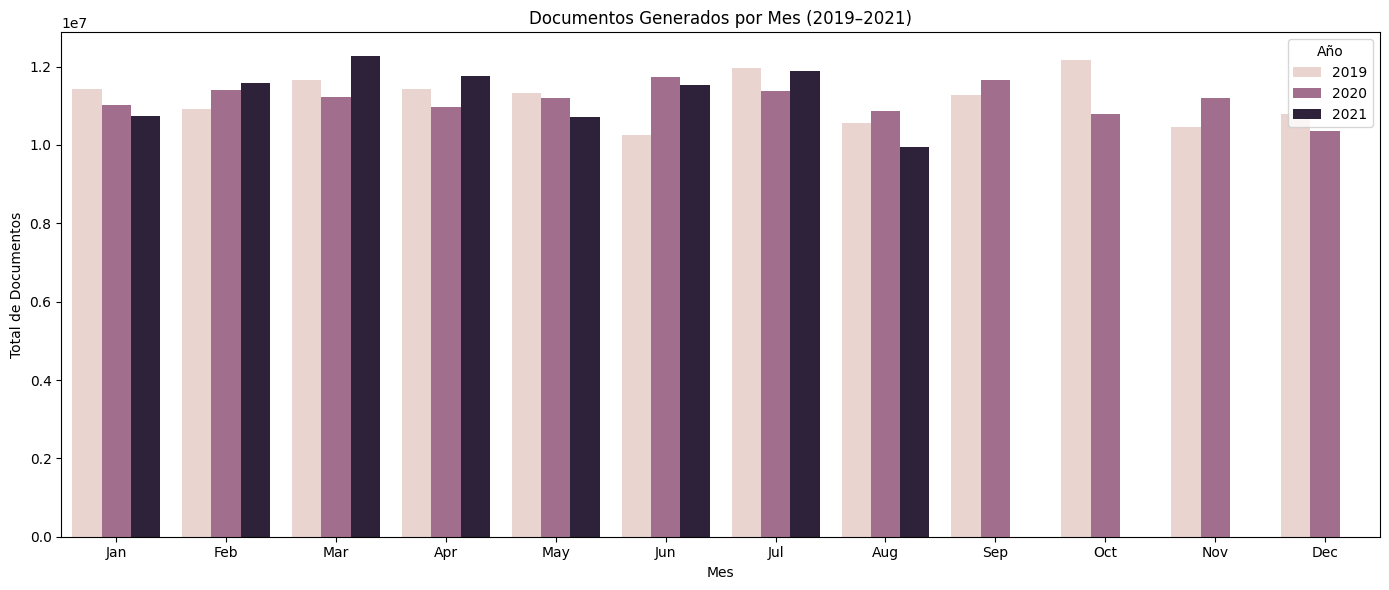

In [71]:
plt.figure(figsize=(14, 6))
sns.barplot(data=doc_por_mes, x='Mes', y='Documentos', hue='Año')

plt.title("Documentos Generados por Mes (2019–2021)")
plt.xlabel("Mes")
plt.ylabel("Total de Documentos")
plt.legend(title='Año')
plt.tight_layout()
plt.show()

## Distribución regional

Agrupar por provincia y ccaa y calcular el num de docs. Cruzar los datos con /spain-provinces.json (uso de la librería geopandas para leer el archivo) para tener la figura de la provincia junto a los docs. Ir dibujando el número total por provincia en el centroide de la figura (provincia correspondiente). Añadir color gradual, flechas, texto para mayor claridad

In [ ]:
docs_por_provincia = df_documentos.groupby(['Provincia', 'CCAA'])['Documentos'].sum().reset_index().sort_values(by='Documentos',
                                                                                                                ascending=False)

docs_por_provincia['Provincia'] = docs_por_provincia['Provincia'].str.lower()

provincias_gdf = gpd.read_file(main_dataset_path+"/spain-provinces.geojson")
provincias_gdf['name'] = provincias_gdf['name'].str.strip().str.lower()

mapa_docs = provincias_gdf.merge(docs_por_provincia,
                                 left_on='name',
                                 right_on='Provincia')

comunidades = mapa_docs['CCAA'].unique()
ccaa_nombres = {
    'C-M': 'Castilla-La Mancha',
    'CyL': 'Castilla y León',
    'Ex': 'Extremadura',
    'MC': 'Región de Murcia',
    'CACeu': 'Ceuta',
    'CAMel': 'Melilla',
    'IB': 'Islas Baleares',
    'RdM': 'Región de Murcia'
}

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1760: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 1.
  self.bins = quantile(y, k=k)


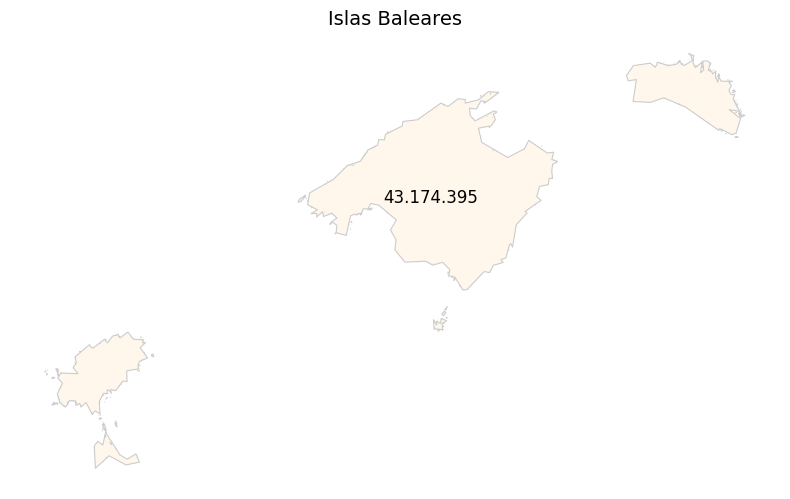

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1760: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 1.
  self.bins = quantile(y, k=k)


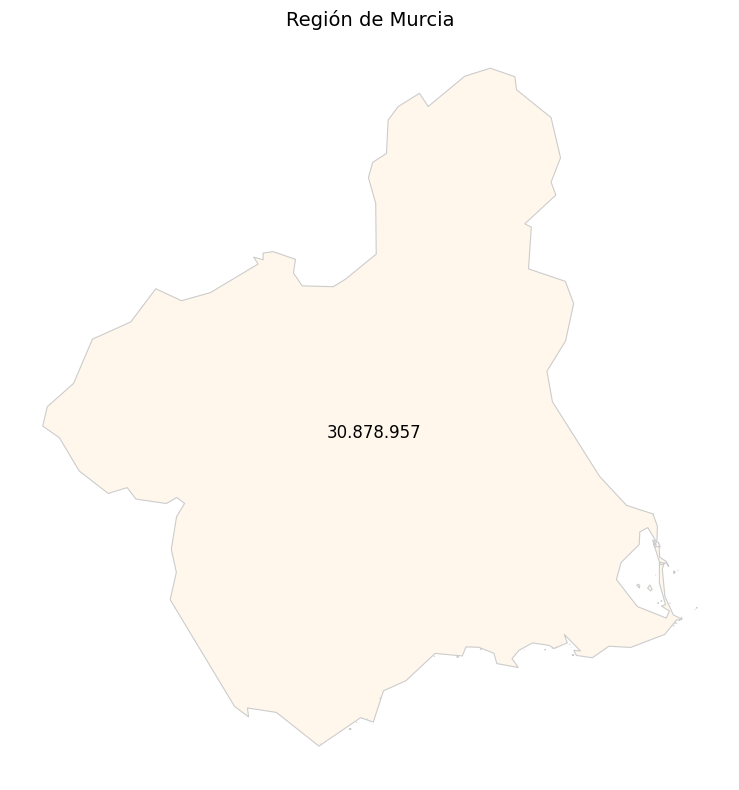

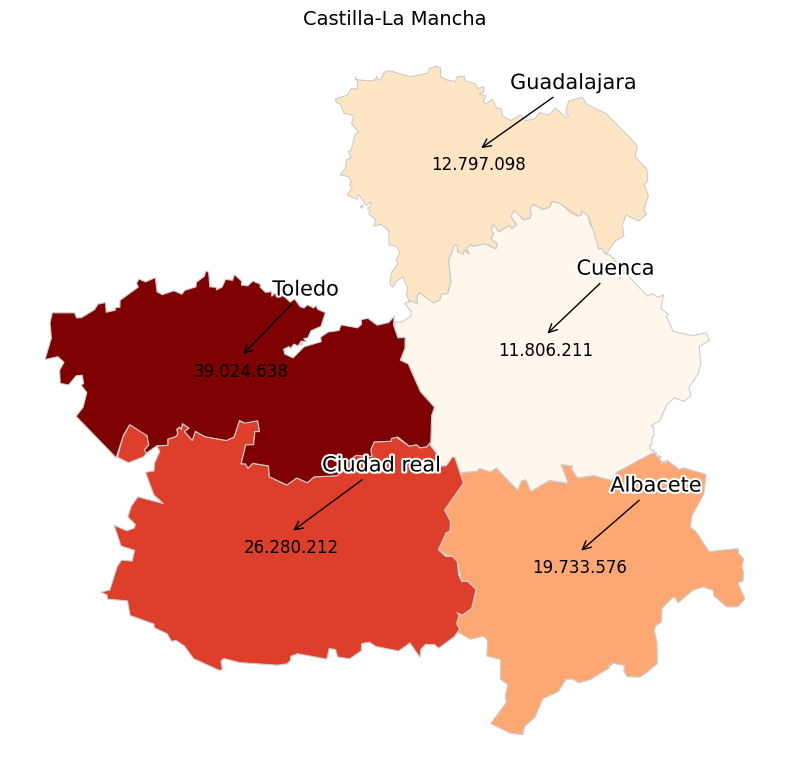

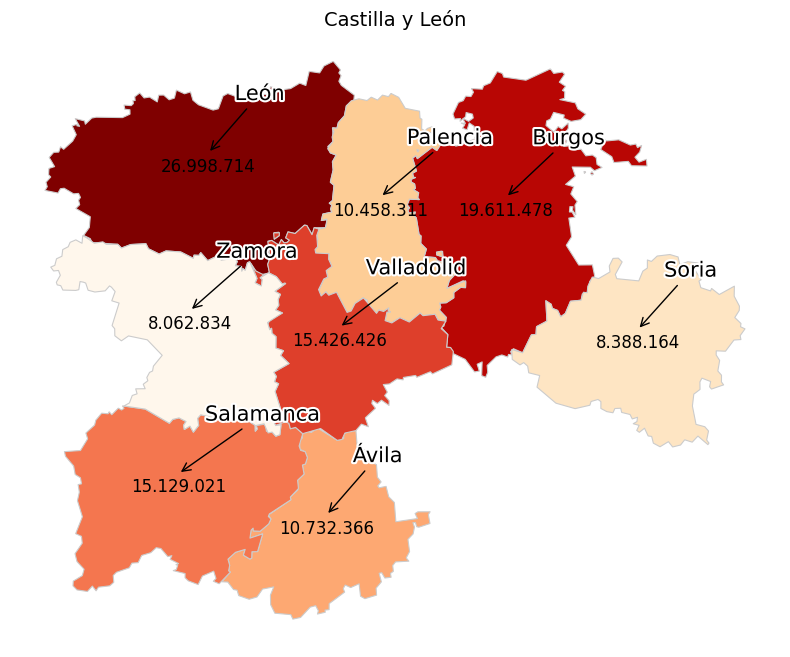

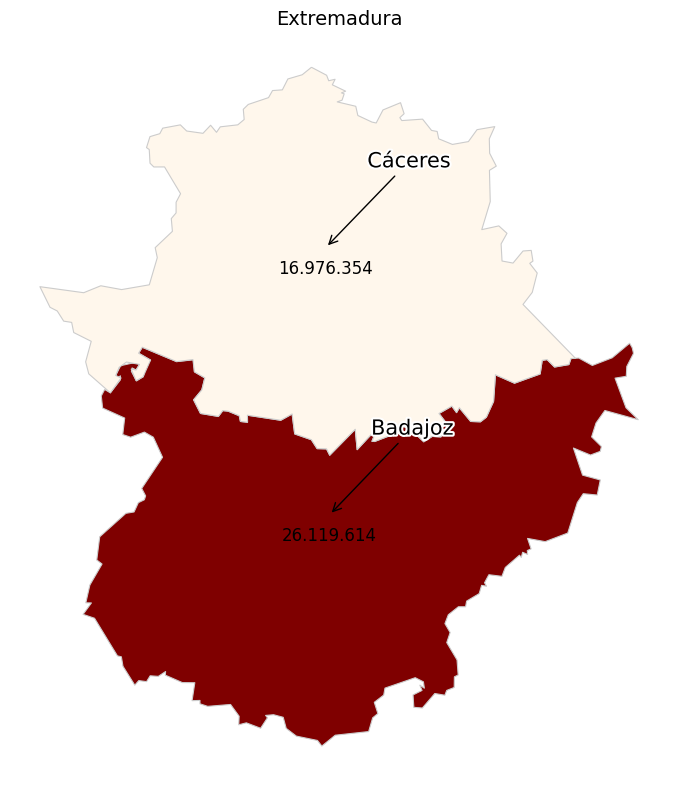

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1760: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 1.
  self.bins = quantile(y, k=k)


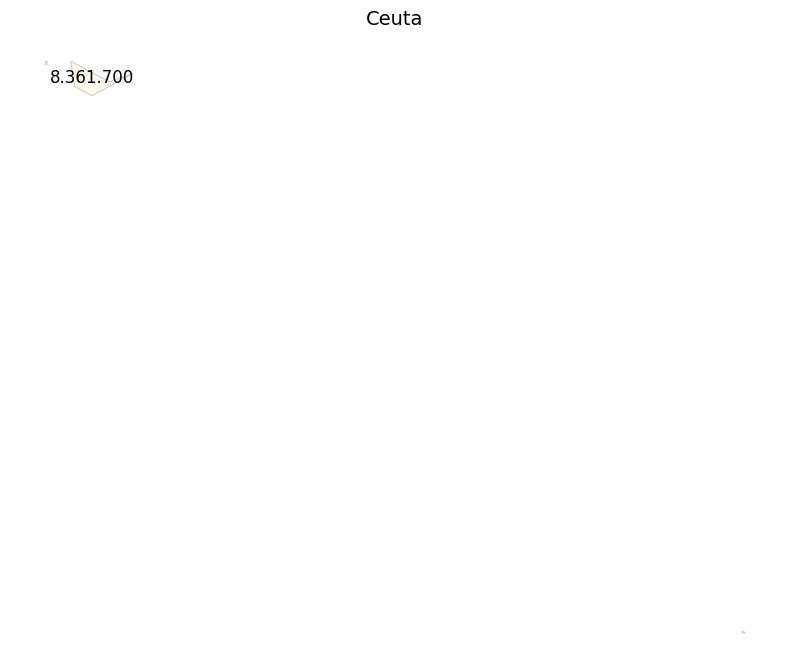

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1760: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 1.
  self.bins = quantile(y, k=k)


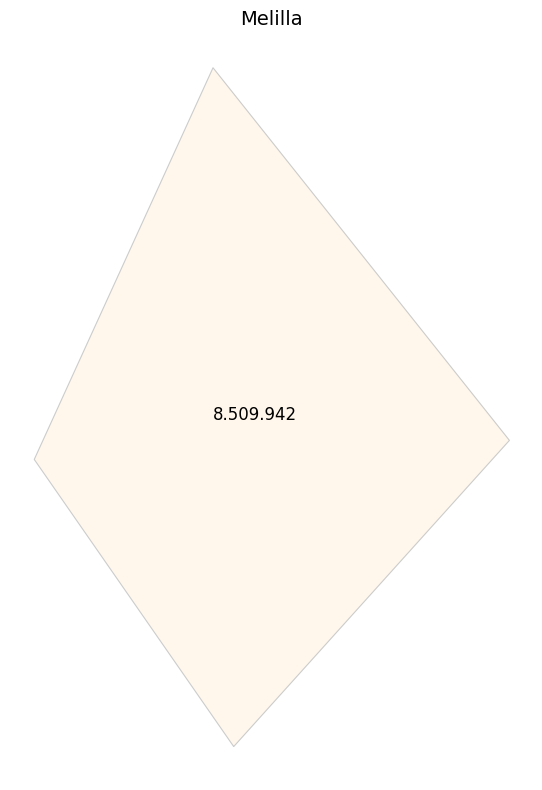

In [90]:
for ccaa in comunidades:
    mapa_ccaa = mapa_docs[mapa_docs['CCAA'] == ccaa]

    fig, ax = plt.subplots(figsize=(8, 8))

    mapa_ccaa.plot(
        column='Documentos',
        cmap='OrRd',
        linewidth=0.8,
        edgecolor='0.8',
        ax=ax,
        legend=False,
        scheme='quantiles',
        k=8
    )

    if len(mapa_ccaa) > 1:
        for _, row in mapa_ccaa.iterrows():
            centroid = row['geometry'].centroid
            offset_x = 0.2
            offset_y = 0.2
            ax.annotate(
                row['Provincia'].capitalize(),
                xy=(centroid.x, centroid.y+ 0.5 *offset_y),
                xytext=(centroid.x + offset_x, centroid.y + 2*offset_y),
                arrowprops=dict(arrowstyle='->', color='black'),
                fontsize=15,
                path_effects=[pe.withStroke(linewidth=3, foreground='white')]
            )
    for idx, row in mapa_ccaa.iterrows():
        centroid = row['geometry'].centroid
        doc_texto = f"{int(row['Documentos']):,}".replace(',', '.')
        ax.text(centroid.x, centroid.y, doc_texto, ha='center', fontsize=12)

    titulo = ccaa_nombres.get(ccaa, ccaa)
    ax.set_title(titulo, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

## Distribución por orden juridisccional

In [12]:
df_documentos_por_tipo = df_documentos.groupby('Orden Jurisdiccional')['Documentos'].sum().reset_index()
df_documentos_por_tipo['Orden Jurisdiccional'] = df_documentos_por_tipo['Orden Jurisdiccional']

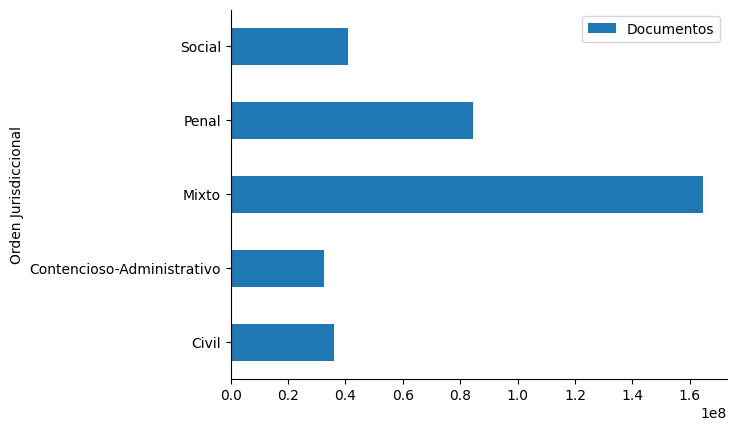

In [13]:

df_documentos_por_tipo.plot(kind='barh', x='Orden Jurisdiccional', y='Documentos')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Ejemplo de soluciones por sector

## Gráfico de dispersión para evaluación de rendimiento (reforma CGPJ)

Preprocesar las vigencias y calcular el periodo de vigencias por juez. Juntar los datos con los documentos segun la unidad funcional y filtrar si la vigencia está dentro de las fechas recogidas. Contar cuantos documentos ha generado cada juez agrupando por un id del juez anteriormente añadido (es el propio índice). Tranformaciones de los periodos a años y graficación de la dispersión añadiendo CCAA como dimensión (color)

In [82]:
vigencias = pd.read_json(f'{main_dataset_path}/vigencias.json')

In [83]:
vigencias['Desde'] = pd.to_datetime(vigencias['Desde'], unit='ms')
vigencias['Hasta'] = pd.to_datetime(vigencias['Hasta'], unit='ms')

vigencias['Nombre'] = vigencias['Nombre'] + ' ' + vigencias['Apellido1'] + ' ' + vigencias['Apellido2']
vigencias['Vigencia'] = vigencias['Hasta'] - vigencias['Desde']

vigencias = vigencias.reset_index().rename(columns={"index": "vigencia_id"})

In [84]:
merged = df_documentos.merge(vigencias, on='Unidad Funcional')

dentro_vigencia = merged[
    (merged['Fecha'] >= merged['Desde']) &
    (merged['Fecha'] <= merged['Hasta'])
]

In [85]:
conteo = dentro_vigencia.groupby('vigencia_id')['Documentos'].sum()
vigencias['Documentos'] = vigencias['vigencia_id'].map(conteo).fillna(0).astype(int)

vigencias['Vigencia'] = pd.to_timedelta(vigencias['Vigencia'])
vigencias['Vigencia'] = vigencias['Vigencia'].dt.days
vigencias['Vigencia_meses'] = vigencias['Vigencia'] / 30
vigencias['Vigencia_años'] = vigencias['Vigencia'] / 365


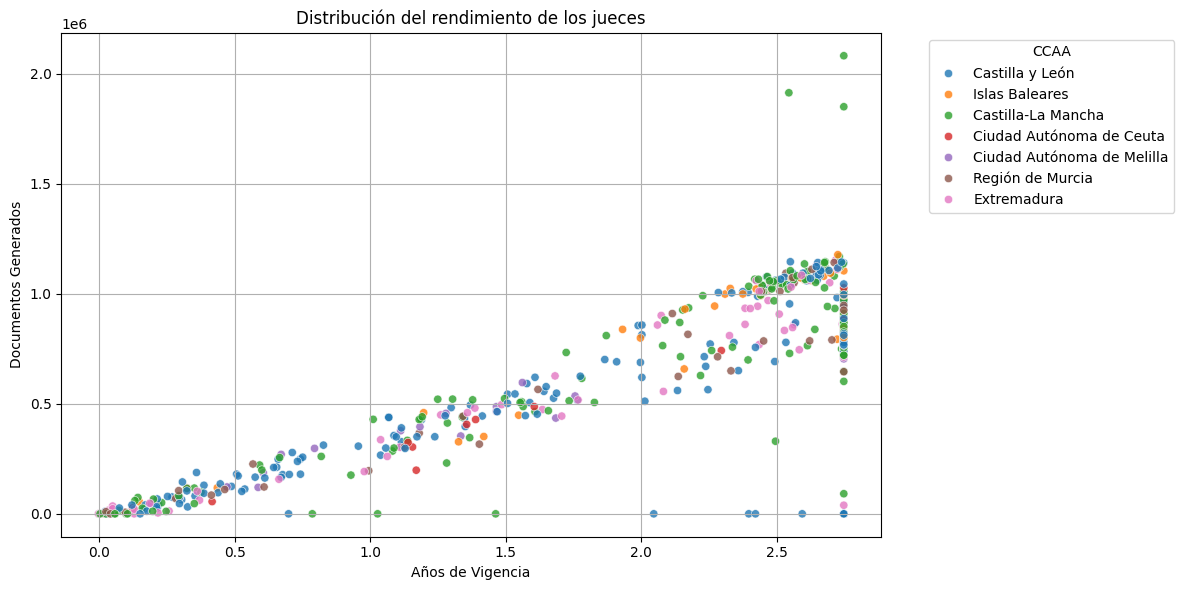

In [86]:
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=vigencias,
    x='Vigencia_años',
    y='Documentos',
    hue='CCAA',
    palette='tab10',
    alpha=0.8
)

plt.title("Distribución del rendimiento de los jueces")
plt.xlabel("Años de Vigencia")
plt.ylabel("Documentos Generados")
plt.legend(title='CCAA', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

## Top 10 juzgados con mayor coeficiente de saturación (documentos/habitantes municipio)

Agrupación por unidad funcional y cálculo de coefinciente de saturación. Graficación gráfico de barras horiztonales

In [84]:
juzgados=df_documentos.groupby('Unidad Funcional')['Documentos'].sum()
juzgados = juzgados.reset_index().merge(df_documentos[['Unidad Funcional','Poblacion']].drop_duplicates(),
                                        on='Unidad Funcional',
                                        how='left').set_index('Unidad Funcional')

juzgados['Coeficiente de saturación'] = juzgados['Documentos'] / juzgados['Poblacion']

/tmp/ipython-input-86-1930023937.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


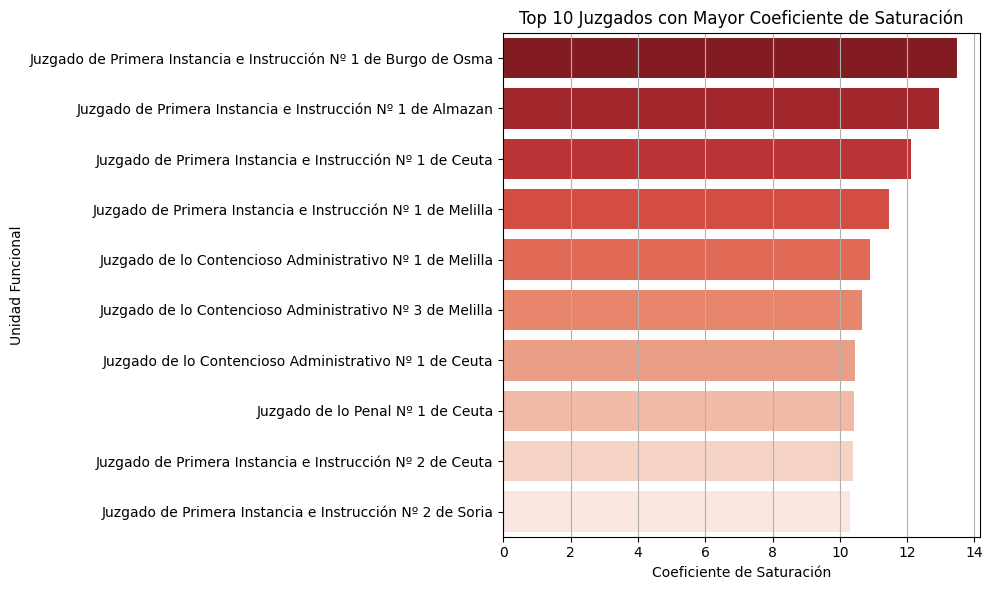

In [ ]:
top10 = juzgados.sort_values('Coeficiente de saturación', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    x='Coeficiente de saturación',
    y=top10.index,
    palette='Reds_r' # degradado mejora visual
)

plt.title('Top 10 Juzgados con Mayor Coeficiente de Saturación')
plt.xlabel('Coeficiente de Saturación')
plt.ylabel('Unidad Funcional')
plt.tight_layout()
plt.show()


## Top 10 juzgados por orden juridisccional (civil, penal y mercantil) con mayor coeficiente de congestión (documentos por días activos)

filtrar por orden juridisccional, calcular los dias activos de cada juzgado y los documentos generados. Calcular el coeficiente.

Para graficar uso de gráfico de barras polar (por variedad)

In [ ]:
def clasificar_juzgado(row):
    tipo = row['Tipo Unidad Funcional'].lower()
    if 'mercantil' in tipo:
        return 'Mercantil'
    elif row['Orden Jurisdiccional'] == 'Penal':
        return 'Penal'
    elif row['Orden Jurisdiccional'] == 'Civil':
        return 'Civil'
    else:
        return 'Otro'

# uso de esta función debido a problemas con las ordenes mercantiles
df_documentos['Rama Relevante'] = df_documentos.apply(clasificar_juzgado, axis=1)

ordenes_interes = ['Civil', 'Penal', 'Mercantil']
dfdocumentos_de_interes = df_documentos[df_documentos['Rama Relevante'].isin(ordenes_interes)]

dias_activos = dfdocumentos_de_interes.groupby(['Unidad Funcional'])['Fecha'].nunique().reset_index()
dias_activos.rename(columns={'Fecha': 'Dias Activos'}, inplace=True)

docs_totales = dfdocumentos_de_interes.groupby(['Unidad Funcional'])['Documentos'].sum().reset_index()

info_aux = dfdocumentos_de_interes.groupby('Unidad Funcional').agg({
    'Provincia': 'first',
    'Rama Relevante': 'first'
}).reset_index()

panel = docs_totales.merge(dias_activos, on='Unidad Funcional').merge(info_aux, on='Unidad Funcional')
panel['Indice Congestion'] = panel['Documentos'] / panel['Dias Activos']

panel['Unidad Funcional'] = panel['Unidad Funcional'].str.replace('Juzgado de ', '')
panel['Unidad Funcional'] = panel['Unidad Funcional'].str.replace('Juzgado  De ', '')
panel['Unidad Funcional'] = panel['Unidad Funcional'].str.replace('Primera Instancia ', 'PI ')


In [98]:
def polar_chart(data, rama):
    df = data.sort_values('Indice Congestion', ascending=False).head(10)
    df = df.reset_index(drop=True)
    labels = df['Unidad Funcional']
    values = df['Indice Congestion']
    angles = [n / float(len(values)) * 2 * pi for n in range(len(values))]

    colors= {
        'Civil': 'darkblue',
        'Penal': 'darkred',
        'Mercantil': 'darkgreen'
    }

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    bars = ax.bar(angles, values - 700, width=0.35, color=colors[rama], alpha=0.7)

    ax.set_xticks(angles)
    ax.set_xticklabels(labels, fontsize=10)

    ticks = ax.get_yticks()
    ax.set_yticklabels([f"{int(t + 700)}" for t in ticks])
    for label, angle in zip(ax.get_xticklabels(), angles):
      label.set_rotation(angle * 180 / pi - 90)
      label.set_horizontalalignment('right')

    plt.title(f"Top 10 Congestión Judicial – {rama}", y=1.1)
    plt.tight_layout()
    plt.show()



/tmp/ipython-input-98-1745949732.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(t + 700)}" for t in ticks])


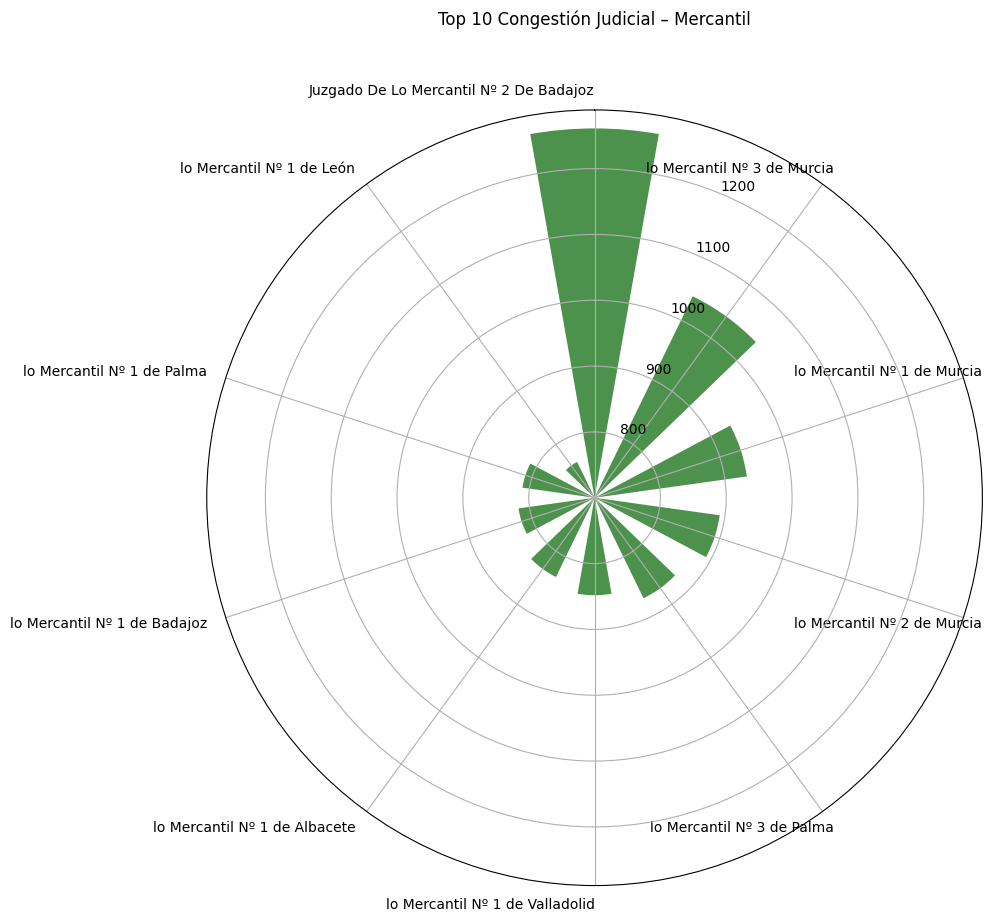

/tmp/ipython-input-98-1745949732.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(t + 700)}" for t in ticks])


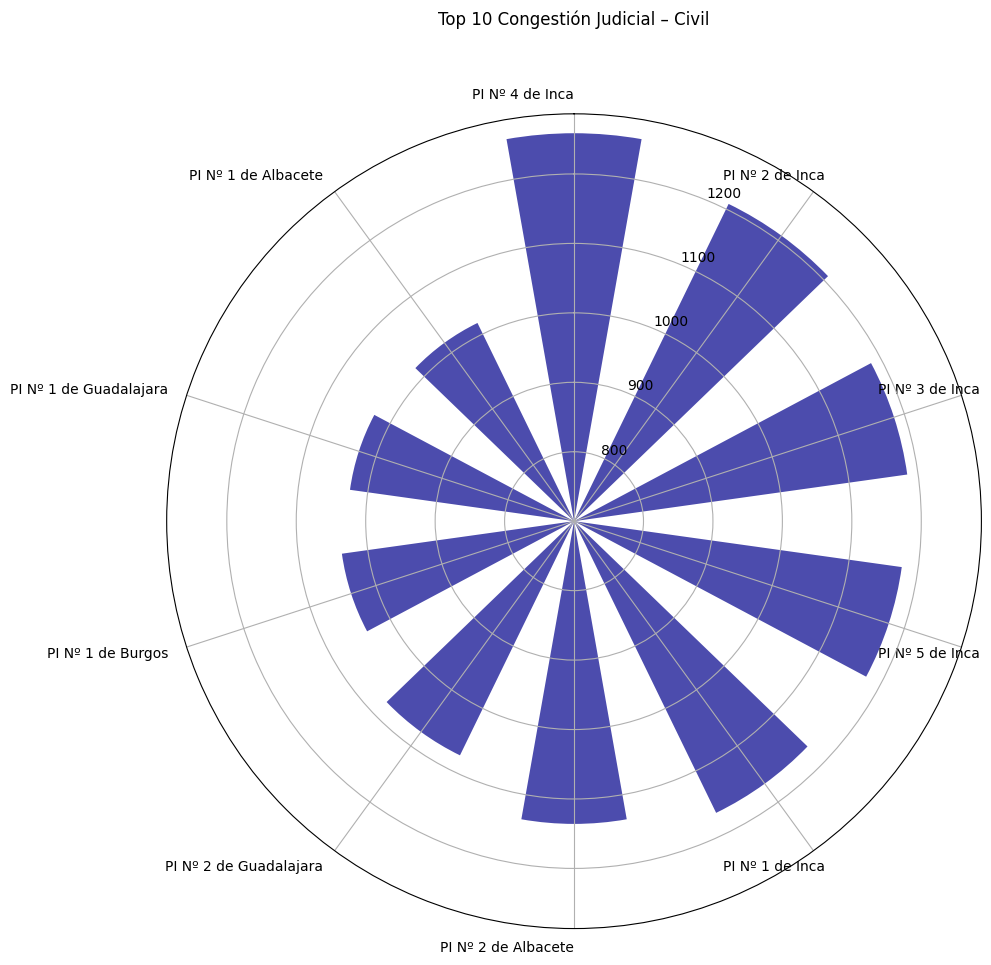

/tmp/ipython-input-98-1745949732.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(t + 700)}" for t in ticks])


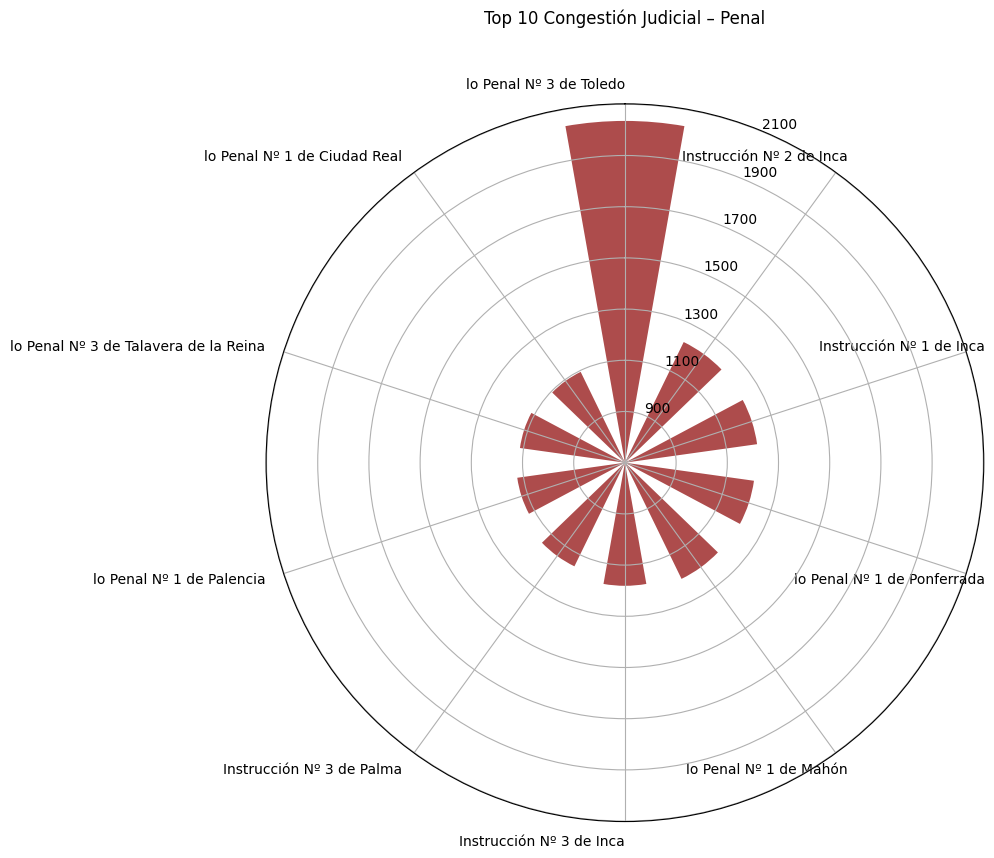

In [99]:
polar_chart(panel[panel['Rama Relevante'] == 'Mercantil'], 'Mercantil')
polar_chart(panel[panel['Rama Relevante'] == 'Civil'], 'Civil')
polar_chart(panel[panel['Rama Relevante'] == 'Penal'], 'Penal')
